In [ ]:
import scprep
scprep.io.download.download_google_drive('1VuddKA7Xa23NAFKvRUmtuND16eEMHL9z', '/content/r_packages.tar.gz')
!tar xzf /content/r_packages.tar.gz && rm /content/r_packages.tar.gz
!apt-get install -yqq libgsl-dev=2.4+dfsg-6
!echo "R_LIBS_USER='/content/.r_packages'" >> ~/.Renviron

In [64]:
# %load /home/dan/.jupyter/firstcell.py
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

font = {'size'   : 12}
mpl.rc('font', **font)

import numpy as np
import pandas as pd
from scipy import stats

import scprep
import phate
import meld
import graphtools as gt
from sklearn.decomposition import PCA
from sklearn import cluster
from sklearn.manifold import TSNE
import umap
import time

from scipy import sparse

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate Synthetic Data with Known Ground Truth

### Introduction to Splatter

Splatter, [Zappia L, et al. Genome Biology. 2017](https://doi.org/10.1186/s13059-017-1305-0), is a tool for simulating single-cell RNA-sequencing data with a known topology. Splatter has two main modes: "paths" and "groups." Because we're interested in generating data with a known trajectory structure, we are going to use the `paths` mode.

Splatter has a bunch of other parameters you can choose from, and if you have time, feel free to play around with the various options.



#### Generating simulated data

Unfortunately, Splatter is only implemented in R. Fortunately, we provide a wrapper in the `scprep.run` module. You can call Splatter from Python using [`scprep.run.SplatSimulate()`](https://scprep.readthedocs.io/en/stable/reference.html#scprep.run.SplatSimulate).

In [33]:
# Run Splatter

# You can easily change the number of paths and cells here
n_paths = 3
cells_per_path = 1000

# Splatter returns a `dict` objbect that contains a bunch of useful information
results = scprep.run.SplatSimulate(
                        method='paths', 
                        batch_cells=cells_per_path * n_paths, 
                        group_prob=np.tile(1/n_paths, n_paths), 
                        n_genes=5000,
                        de_down_prob=0.5,
                        path_from=[0,0,0],
                        mean_shape=1,
                        seed=42)

R[write to console]: Getting parameters...
R[write to console]: Creating simulation object...
R[write to console]: Simulating library sizes...
R[write to console]: Simulating gene means...
R[write to console]: Simulating path endpoints...
R[write to console]: Simulating path steps...
R[write to console]: Simulating BCV...
R[write to console]: Simulating counts...
R[write to console]: Simulating dropout (if needed)...
R[write to console]: Done!


Let's check what we can find in this `results` dictionary. Note, you can find explanations of what each key refers to by checking the `returns` section of the `SplatSimulate` docstring or consulting https://scprep.readthedocs.io/en/stable/reference.html#scprep.run.SplatSimulate.

In [34]:
results.keys()

dict_keys(['counts', 'group', 'step', 'batch', 'exp_lib_size', 'base_gene_mean', 'outlier_factor', 'batch_cell_means', 'base_cell_means', 'bcv', 'cell_means', 'true_counts', 'dropout', 'de_fac_1', 'de_fac_2', 'de_fac_3', 'sigma_fac_1', 'sigma_fac_2', 'sigma_fac_3'])

There's a lot of organizational stuff happening in the next code block. The key idea is that we want to grab three pieces of information from `results`:
* `counts` - simulated expression counts
* `group` - the group or path the cell belongs to
* `step` - how far along the path each cell is

We're putting `counts` into one DataFrame and `group` & `step` in a separate DataFrame. Then we do some manipulation of the `step` vector so it increases monotonically (as opposed to restarting at 0 at the beginning of each path). Finally we change the name of the `Index` of `data` and `metadata` and preprocess the data.

In [43]:
# Put counts data in DataFrame
data = pd.DataFrame(results['counts'])

# Put metadata in a DataFrame
metadata = pd.DataFrame([results['step'], results['group']], index=['step', 'group']).T
metadata = metadata.astype({'step': int}) # These are strings by default, but we want ints

# Adjusting the 'step' vector to monotonically increase
p1_mask = metadata['group'] == 1
metadata.loc[p1_mask, 'step'] = 100 - metadata.loc[p1_mask, 'step']
p23_mask = np.isin(metadata['group'], [2,3])
metadata.loc[p23_mask, 'step'] = 100 + metadata.loc[p23_mask, 'step']

# Change DataFrame index names to be a little nicer
new_index = pd.Index(['cell_{}'.format(i) for i in range(metadata.shape[0])])
data.index = new_index
metadata.index = new_index

# Library-size normalize and sqrt transform
data = scprep.normalize.library_size_normalize(data)
data = scprep.transform.sqrt(data)

#### Visualizing the data

Splatter is designed to generate data that can be easily visualized using PCA. If you have time, try to visualize the data using other tools from our visualization module.

In [36]:
data_pca = PCA(100).fit_transform(data)
data_pca = pd.DataFrame(data_pca, index = data.index)

Plot the data using `scprep.plot.scatter2d()`.

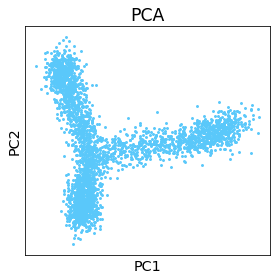

In [37]:
ax = scprep.plot.scatter2d(data_pca, color='#5ac8fa',
                      ticks=None, title='PCA', 
                      label_prefix='PC',
                      figsize=(4,4))

ax.figure.tight_layout()

#### Plot the `step` vector

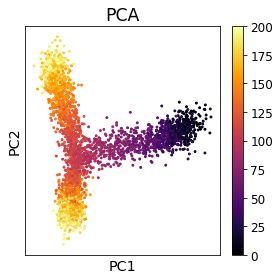

In [44]:
ax = scprep.plot.scatter2d(data_pca, c=metadata['step'],
                      ticks=None, title='PCA', 
                      label_prefix='PC',
                      figsize=(4,4))

ax.figure.tight_layout()

#### Plot the `group` vector

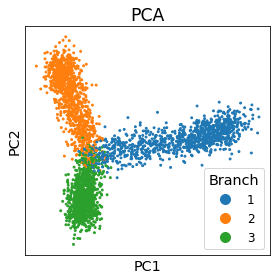

In [50]:
ax = scprep.plot.scatter2d(data_pca, c=metadata['group'],
                      legend_title='Branch',
                      ticks=None, title='PCA', 
                      label_prefix='PC',
                      figsize=(4,4))

ax.figure.tight_layout()

#### Assign each cell to a day using a binomal distribution

To make it easier to understand the benefit of pseudotime analysis, we're going to assign each cell to a sample labelled `Day1`, `Day2`, or `Day3` to mimic a traditional time course experiment. Note that we're not using the `counts` data to do this, but rather we're using the _latent variable_ `step` to assign samples. This means the we're using the same latent variable to generate counts and independently generate the `sample` labels.

In [52]:
# This random distribution will have increased probability of generating a `2` 
# as the `step` gets larger.
normalized_step = metadata['step'] / metadata['step'].max()
sample = np.random.binomial(n = 2,
                            p = normalized_step, 
                            size=metadata.shape[0]) + 1


sample_cmap = {1 : '#a8ddb5',
       2: '#4eb3d3',
       3: '#08589e'}

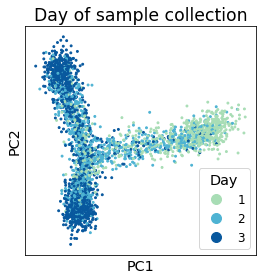

In [54]:
ax = scprep.plot.scatter2d(data_pca,  c=sample, cmap=sample_cmap,
                           legend_title='Day',
                           label_prefix='PC',
                      ticks=None, title='Day of sample collection', 
                      legend=True, figsize=(3.8,4))

## 2. Learning Diffusion Pseudotime (DPT)

In this section, we're going to run diffusion pseudotime (DPT) from scratch. Yes, there is a nice wrapper we will use later. For now, we want to show you _how_ DPT is calculated.

Calculating DPT has 7 steps:
1. Learn a graph from the data using local Euclidean distances
2. Calculate the first eigenvector of the diffusion operator
3. Subtract the first eigenvector from the diffusion operator
4. Calculate the limit of all random walks on the graph
5. Calculate pairwise distances in the random walk space
6. Pick a root cell
7. Calculate branches using correlation/anti-correction

This is a fairly complicated algorithm, but it will be helpful to see how something like this works under the hood.

### Step 1 - Learn a graph from the counts data 

Here, we're using `graphtools` to learn a graph from data. If you remember from the manifold learning section, the key to learning a graph from data is to calculate _local Euclidean distances_ and then connect cells that are in the same _neighborhood_. We can do this in one line by calling `gt.Graph()`.

The full graphtools API can be found here: https://graphtools.readthedocs.io/en/stable/reference.html#module-graphtools.api

In [55]:
G = gt.Graph(data, n_pca=100, use_pygsp=True)

### Step 2 - Calculate the first eigenvector of the diffusion operator

Now, we know that even though eigenvectors are important, they are incredibly abstract and confusing. The more important concept here is to understand the _diffusion operator_. The diffusion operator is so useful that it is calculated whenever you build a graph with `graphtools`.

The diffusion operator is usually defines as "the row-stochastic form of the kernel matrix." The key terms here are:
* kernel matrix, $\mathbf{K}$ - the matrix of size $n \times n$ where $n$ is the number of vertices in the graph. Each entry $\mathbf{K}_{i,j}$ contains the weight of the edge connecting vertex $i$ and vertex $j$.
* row-stochastic - this is a fancy term to describe the fact that each row of a matrix sums to $1$.

A row-stochastic kernel matrix has edge weights scaled such that they could represent the probability of moving from one vertex to another. This is the heart of the "random-walk" along a graph. If you Google "[graph random walk](https://www.google.com/search?q=graph+random+walk&oq=graph+random+walk)", you'll find a ton a resources on the topic.

Let's compare the row-sums of `G.K`, the kernel matrix, and `G.diff_op`, the diffusion operator.

In [59]:
# Which axis do we need to sum across to get the row-sum?
axis = ??????
print(G.K.sum(axis=axis))
print(G.diff_op.sum(axis=axis))

[[16.97475216]
 [10.78225077]
 [17.68777384]
 ...
 [42.08375603]
 [14.67941494]
 [ 6.71532723]]
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


By default, `G.diff_op` is a sparse matrix, because so many entries are `0`. You can confirm this using `type(G.diff_op)` which should return `scipy.sparse.csr.csr_matrix`. This means we can calculate the first eigenvector efficeiently using `scipy.sparse.linalg.eigs()`.

In [68]:
# If you look at the top, we already imported the `sparse` module from `scipy`
W, V = sparse.linalg.eigs(G.diff_op, k=1)

# W is the eigenVALUE matrix and V is the eigenVECTOR matrix
# We only care about eigenVECTORS here
V_0 = V @ V.T

V_tilde = G.diff_op.toarray() - (V[:,0] @ V[:,0].T)

In [454]:
class DiffusionPseudotime():
    
    def fit(data)
        G = gt.Graph(data, n_pca=100, use_pygsp=True)
        
        # Calculate eigenvectors of the diffusion operator
        # May be faster way to do this
        W, V = sparse.linalg.eigs(G.diff_op, k=1)
        
        # Remove first eigenspace
        V_tilde = G.diff_op.toarray() - (V[:,0] @ V[:,0].T)
        
        # Calculate M
        T = V_tilde
        I = np.eye(T.shape[1])
        M = np.linalg.inv(I - T) - I
        
        # Calc DPT
        DPT = squareform(pdist(M))
        
        self.DPT = DPT
        return DPT
    
    def transform(root_cell):
        self.pseudotime = self.DPT[root_cell]
        return self.pseudotime
    
    def calculate_inverse_pseudotime(end_cell):
        self.inv_pseudotime = self.DPT[end_cell]
        return self.inv_pseudotime
    
    def fit_transform(data, root_cell):
        self.fit(data)
        return self.transform(root_cell)

In [455]:
data_pca = PCA(2).fit_transform(np.sqrt(data_ln))

In [467]:
steps / np.max(steps)

200

In [475]:
sample = np.random.binomial(2, steps / np.max(steps), size=steps.shape[0])
sample = ['Day{}'.format(i+1) for i in sample]


sample_cmap = {'Day1' : '#a8ddb5',
       'Day2': '#4eb3d3',
       'Day3': '#08589e'}

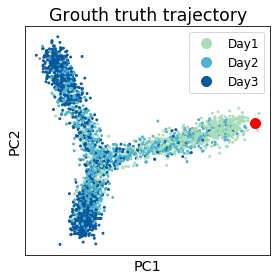

In [500]:
fig, ax = plt.subplots(1, figsize=(4,4))

start_cell = np.argsort(steps.values)[3]
ax.scatter(data_pca[start_cell,0], data_pca[start_cell,1], c ='red', s=100, zorder=10)

scprep.plot.scatter2d(data_pca, c =sample, cmap=sample_cmap, 
                      ticks=None, title='Grouth truth trajectory', 
                      legend=True, label_prefix='PC',
                      ax=ax)

fig.tight_layout()
fig.savefig('../img/diffusion.simulation.sample_labels.png', dpi=300)

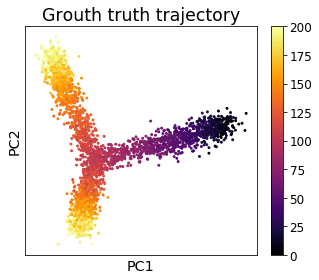

In [539]:
ax = scprep.plot.scatter2d(data_pca, label_prefix='PC', c=steps,
                      ticks=None, title='Grouth truth trajectory', 
                      discrete=False, legend=True,
                     figsize=(4.6,4))
ax.figure.tight_layout()
ax.figure.savefig('../img/diffusion.simulation.ground_truth_trajectory.png', dpi=300)

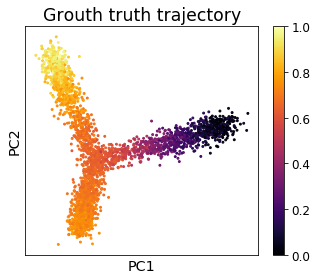

In [541]:
ax = scprep.plot.scatter2d(data_pca, label_prefix='PC', c=dpt,
                      ticks=None, title='Grouth truth trajectory', 
                      discrete=False, legend=True,
                     figsize=(4.6,4))
ax.figure.tight_layout()
#ax.figure.savefig('../img/diffusion.simulation.ground_truth_trajectory.png', dpi=300)

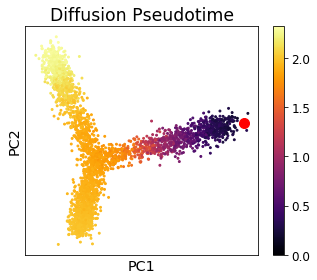

In [503]:


fig, ax = plt.subplots(1, figsize=(4.6,4))
ax.scatter(data_pca[start_cell,0], data_pca[start_cell,1], c ='red', s=100, zorder=10)

scprep.plot.scatter2d(data_pca, c = DPT[start_cell], 
                      ticks=None, title='Diffusion Pseudotime', 
                      discrete=False, legend=True,label_prefix='PC',
                      ax=ax)

fig.tight_layout()
fig.savefig('../img/diffusion.simulation.dpt.png', dpi=300)

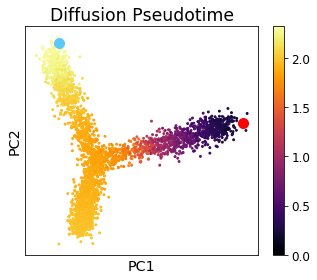

In [507]:
fig, ax = plt.subplots(1, figsize=(4.6,4))
ax.scatter(data_pca[start_cell,0], data_pca[start_cell,1], c ='red', s=100, zorder=10)

end_cell = np.argmax(DPT[start_cell])
ax.scatter(data_pca[end_cell,0], data_pca[end_cell,1], color=[90/255, 200/255, 250/255], s=100, zorder=10)

scprep.plot.scatter2d(data_pca, c = DPT[start_cell], 
                      ticks=None, title='Diffusion Pseudotime', 
                      discrete=False, legend=True,label_prefix='PC',
                      ax=ax)

fig.tight_layout()
fig.savefig('../img/diffusion.simulation.dpt2.png', dpi=300)

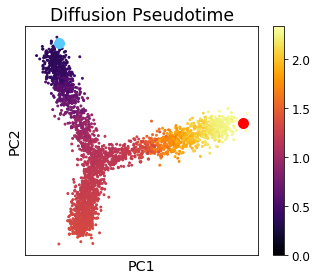

In [508]:
fig, ax = plt.subplots(1, figsize=(4.6,4))
ax.scatter(data_pca[start_cell,0], data_pca[start_cell,1], c ='red', s=100, zorder=10)

end_cell = np.argmax(DPT[start_cell])
ax.scatter(data_pca[end_cell,0], data_pca[end_cell,1], color=[90/255, 200/255, 250/255], s=100, zorder=10)

scprep.plot.scatter2d(data_pca, c = DPT[end_cell], 
                      ticks=None, title='Diffusion Pseudotime', 
                      discrete=False, legend=True,label_prefix='PC',
                      ax=ax)

fig.tight_layout()
fig.savefig('../img/diffusion.simulation.dpt3.png', dpi=300)

In [521]:
import scipy

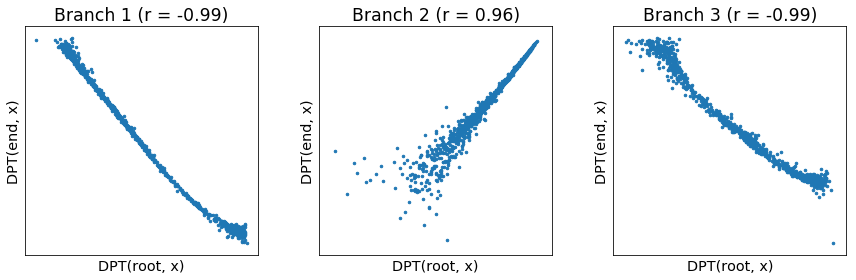

In [524]:
fig, axes = plt.subplots(1,3 ,figsize=(12,4))

for i, ax in enumerate(axes):
    g = sorted(metadata['group'].unique())[i]
    m = metadata['group'] == g
    
    x = DPT[start_cell][m]
    y = DPT[end_cell][m]
    r, p = scipy.stats.pearsonr(x,y)
    scprep.plot.scatter(DPT[start_cell][m], DPT[end_cell][m], 
                        ticks=None, xlabel='DPT(root, x)', ylabel='DPT(end, x)',
                        title='Branch {} (r = {:.2f})'.format(i+1, r),
                        ax=ax)
    
    
    
fig.tight_layout(w_pad=4)
fig.savefig('../img/diffusion.simulation.corr_anticorr.png', dpi=300)

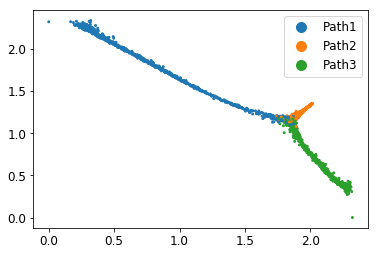

In [510]:
scprep.plot.scatter(DPT[start_cell], DPT[end_cell], c=metadata['group'])

In [3]:
import scprep

# Splatter parameters
# cells_per_path * n_groupsnp.tile(1/n_groups, n_groups)
n_groups = 9
cells_per_path = 1000
params = {'method':'paths', 'batch_cells':cells_per_path * n_groups, 'seed':42, 
         'group_prob':np.tile(1/n_groups, n_groups), 'path_from':[0,1,1,2,2,3,3,4,4], 'n_genes':5000,
         'de_fac_loc':0.2}

# Run Splatter
results = scprep.run.SplatSimulate(**params)

# Assign data to data frame
data = pd.DataFrame(results['true_counts'])

metadata = pd.DataFrame([results['step'], results['group']], index=['step', 'group']).T
metadata = metadata.astype({'step': int})



# Reindex
new_index = pd.Index(['cell_{}'.format(i) for i in range(metadata.shape[0])])
data.index = new_index
metadata.index = new_index

data_ln = scprep.normalize.library_size_normalize(data)

R[write to console]: Getting parameters...
R[write to console]: Creating simulation object...
R[write to console]: Simulating library sizes...
R[write to console]: Simulating gene means...
R[write to console]: Simulating path endpoints...
R[write to console]: Simulating path steps...
R[write to console]: Simulating BCV...
R[write to console]: Simulating counts...
R[write to console]: Simulating dropout (if needed)...
R[write to console]: Done!


In [8]:
data_pca = PCA(100).fit_transform(np.sqrt(data_ln))

In [9]:
phate_op = phate.PHATE()
data_phate = phate_op.fit_transform(data_pca)

Calculating PHATE...
  Running PHATE on 10000 cells and 100 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 14.10 seconds.
    Calculating affinities...
    Calculated affinities in 0.14 seconds.
  Calculated graph and diffusion operator in 14.27 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.00 seconds.
    Calculating KMeans...
    Calculated KMeans in 40.65 seconds.
  Calculated landmark operator in 43.71 seconds.
  Calculating optimal t...
    Automatically selected t = 5
  Calculated optimal t in 3.70 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.23 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 21.23 seconds.
Calculated PHATE in 84.16 seconds.


In [11]:
import umap

In [12]:
data_umap = umap.UMAP().fit_transform(data_pca)

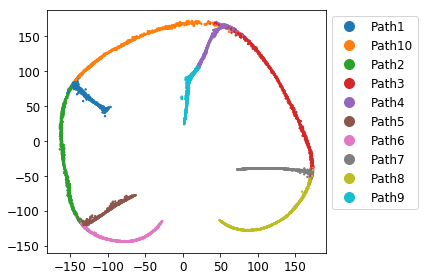

In [18]:
scprep.plot.scatter2d(data_phate, c=metadata['group'], legend_anchor=(1,1))

In [29]:
idx = metadata['step'].loc[metadata['group'] == 'Path1'].idxmin()
idx = np.where(metadata.index == idx)[0][0]

In [30]:
import anndata, scanpy

adata = anndata.AnnData(data_ln)

adata.uns['iroot'] = idx

scanpy.pp.neighbors(adata)
scanpy.tl.diffmap(adata)
scanpy.tl.dpt(adata)

dpt = adata.obs['dpt_pseudotime']

Transforming to str index.


         Falling back to preprocessing with `sc.pp.pca` and default params.


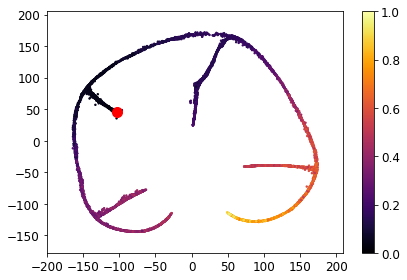

In [35]:
ax = scprep.plot.scatter2d(data_phate, c=dpt, legend_anchor=(1,1))
ax.scatter(data_phate[idx, 0], data_phate[idx, 1], color='red', s=100, zorder=10)

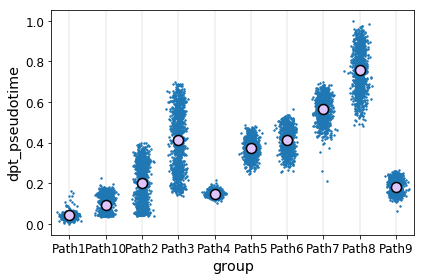

In [36]:
scprep.plot.jitter(metadata['group'], dpt)